# Ants vs Bees with ResNet18



## Introduction

In this exercise, you will build a model to classify images as either ants or bees using a dataset available at the following link: [Hymenoptera Data](https://download.pytorch.org/tutorial/hymenoptera_data.zip). The dataset contains images of ants and bees divided into training and validation folders.

The main objectives of this exercise are:

1. **Preprocess and load** image data using PyTorch utilities.
2. Use a **pre-trained ResNet-18** backbone to leverage transfer learning for feature extraction.
3. **Train a fully connected (FC)** classification head on top of the ResNet backbone.
4. Monitor **training and validation** metrics, and save the best model to avoid overfitting.
5. **Visualize the performance** of the model by plotting loss and accuracy trends.

![Alt Text](./images/ba4.jpg)

## Importing Required Libraries

 - **PyTorch** Modules: Used for building, training, and optimizing the neural network.
 - **Torchvision**: Contains utilities for handling datasets, models, and transforms.
 - **NumPy**: For numerical operations.
 - **Matplotlib**: For plotting training and validation metrics.
 - **os**: For managing file paths.
 - **tqdm**: For progress bars during training and validation loops.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

## Checking for Device Compatibility

This block ensures the model will run on a *GPU* if available, otherwise on a *CPU*.
For macOS users, the *mps* backend is also checked

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

## Data Preprocessing and Transformation

- **Purpose**: Applies transformations to preprocess the images for training and validation.
- **Training Transformations**:
    - Random crops, flips, rotations, and color jittering augment the data to improve generalization.
    - Normalization scales the images to ensure consistent pixel value ranges, improving model training and convergence.
- **Validation Transformations**:
    - Resizing and center cropping ensure consistent image sizes for inference.

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust color
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## Loading the Dataset

- *datasets.ImageFolder*: Loads the images from the specified directories.
- *DataLoader*: Wraps the datasets for batch processing during training and validation.
- *dataset_sizes*: Stores the sizes of the training and validation datasets.
- *class_names*: Displays the two classes: *['ants', 'bees']*.

In [4]:
data_dir = 'data'  
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [5]:
class_names = image_datasets['train'].classes

# Display the classes
print(f"Classes: {class_names}")

Classes: ['ants', 'bees']


## Visualizing a Batch of Images

- *imshow*: Helper function to display an image after denormalizing it.
- *torchvision.utils.make_grid*: Combines multiple images into a single grid for visualization.
- Displays a batch of images along with their class labels

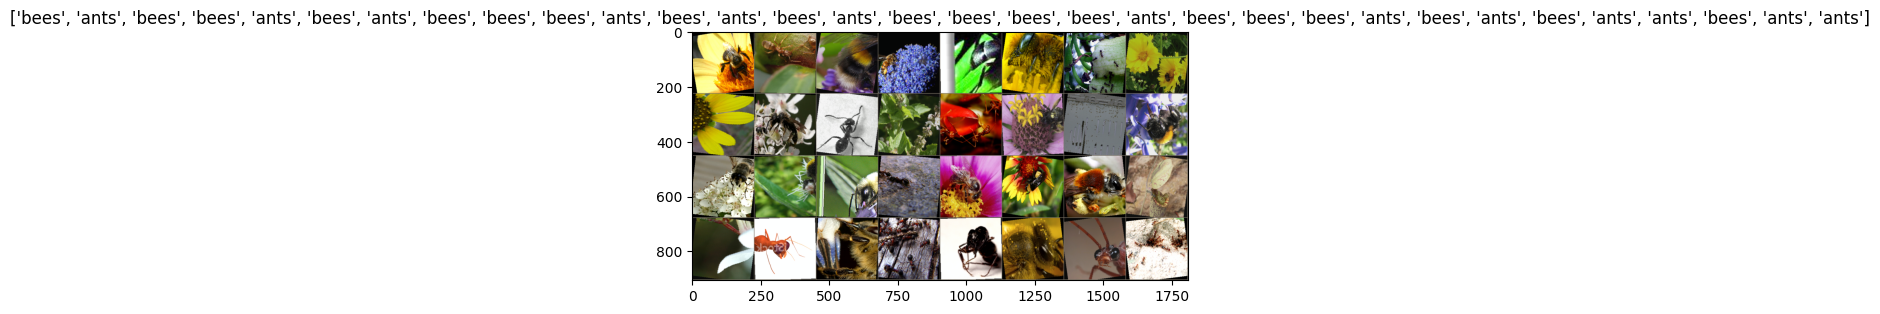

In [6]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

##  Defining the Model

- **Transfer Learning**: The pre-trained ResNet-18 backbone is used for feature extraction.
- **Freezing Weights**: ResNet-18 parameters are frozen to retain pre-trained features.
- **Classification Head** (*fc_model*):
    - A two-layer fully connected network followed by a *Sigmoid* activation function for binary classification.

In [7]:
resnet18_model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18_model.fc = nn.Identity()

for param in resnet18_model.parameters():
    param.requires_grad = False
    
resnet18_model.eval()
resnet18_model = resnet18_model.to(device)

fc_model = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
).to(device)

model = nn.Sequential(
    resnet18_model,
    fc_model
).to(device)

In [8]:
model

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Optimizer and Loss Function

- **Optimizer** (*Adam*):

    - Optimizes the weights of the fully connected classification head (*fc_model.parameters()*).
    - Uses the Adam algorithm, which adapts the learning rate for each parameter for efficient training.
    - **Learning Rate** (*lr=0.001*): Controls how quickly the model updates the weights during training.
- **Loss Function** (*BCEWithLogitsLoss*):

    - Combines a *Sigmoid* activation function and Binary Cross-Entropy Loss.
    - Suitable for binary classification tasks like "ants vs bees."
    - Measures the error between the predicted probabilities and actual labels

In [9]:
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.00075)
loss_fn = nn.BCEWithLogitsLoss()

##  Monitoring Training and Validation Performance

This code trains and validates the model over 80 epochs, using a pre-trained ResNet-18 backbone (kept in evaluation mode) and a trainable fully connected (FC) classification head.

1. **Training Phase**: 
    - *model.train()*: Activates training mode for the FC head.
    - For each batch in the training set:
        - Inputs and labels are sent to the device (CPU/GPU).
        - Forward pass calculates predictions, and the *BCEWithLogitsLoss* computes the error.
        - Backward pass calculates gradients, and *optimizer.step()* updates the FC head’s weights.
        - Accuracy is calculated by comparing predictions (thresholded sigmoid outputs) to true labels.
2. **Validation Phase**:
    - *model.eval()*: Activates evaluation mode for the full model.
    - Gradients are disabled using *torch.no_grad()* to save memory.
    - Validation loss and accuracy are calculated similarly to training but without weight updates.
3. **Metrics**:
    - Average losses and accuracies for training and validation are stored in lists (*train_losses*, *val_losses*, etc.) for each epoch.
4. **Model Checkpointing**:
    - The model’s state is saved after every epoch as *model_epoch_{epoch_number}.pth*.
    

This loop ensures that training and validation progress can be monitored in real-time, and the saved models can be used to select the best-performing epoch.

In [10]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Number of epochs
num_epochs = 80

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print('-' * 10)

    # Training phase
    model.train()
    resnet18_model.eval()  # Keep the backbone in eval mode

    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm.tqdm(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device).type(torch.float).reshape(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_loss_avg = train_loss_sum / len(dataloaders['train'])
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device).type(torch.float).reshape(-1, 1)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss_sum += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss_avg = val_loss_sum / len(dataloaders['val'])
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    # Save the model checkpoint
    torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')

    # Print metrics for this epoch
    print(f"Epoch {epoch + 1}:")
    print(f"Training Loss: {train_loss_avg:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/80
----------


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 1:
Training Loss: 0.6616, Training Accuracy: 0.4959
Validation Loss: 0.5682, Validation Accuracy: 0.5425
Epoch 2/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 2:
Training Loss: 0.5826, Training Accuracy: 0.4959
Validation Loss: 0.5241, Validation Accuracy: 0.5425
Epoch 3/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 3:
Training Loss: 0.5564, Training Accuracy: 0.4959
Validation Loss: 0.5192, Validation Accuracy: 0.5425
Epoch 4/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 4:
Training Loss: 0.5461, Training Accuracy: 0.4959
Validation Loss: 0.5122, Validation Accuracy: 0.5425
Epoch 5/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch 5:
Training Loss: 0.5508, Training Accuracy: 0.4959
Validation Loss: 0.5095, Validation Accuracy: 0.5425
Epoch 6/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 6:
Training Loss: 0.5441, Training Accuracy: 0.4959
Validation Loss: 0.5081, Validation Accuracy: 0.5425
Epoch 7/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 7:
Training Loss: 0.5452, Training Accuracy: 0.4959
Validation Loss: 0.5111, Validation Accuracy: 0.5425
Epoch 8/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 8:
Training Loss: 0.5384, Training Accuracy: 0.4959
Validation Loss: 0.5096, Validation Accuracy: 0.5425
Epoch 9/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch 9:
Training Loss: 0.5353, Training Accuracy: 0.4959
Validation Loss: 0.5080, Validation Accuracy: 0.5425
Epoch 10/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 10:
Training Loss: 0.5300, Training Accuracy: 0.5000
Validation Loss: 0.5091, Validation Accuracy: 0.5425
Epoch 11/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 11:
Training Loss: 0.5382, Training Accuracy: 0.5000
Validation Loss: 0.5148, Validation Accuracy: 0.5425
Epoch 12/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 12:
Training Loss: 0.5310, Training Accuracy: 0.5041
Validation Loss: 0.5096, Validation Accuracy: 0.5490
Epoch 13/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 13:
Training Loss: 0.5334, Training Accuracy: 0.5000
Validation Loss: 0.5085, Validation Accuracy: 0.5425
Epoch 14/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 14:
Training Loss: 0.5389, Training Accuracy: 0.5000
Validation Loss: 0.5066, Validation Accuracy: 0.5490
Epoch 15/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 15:
Training Loss: 0.5381, Training Accuracy: 0.5082
Validation Loss: 0.5081, Validation Accuracy: 0.5490
Epoch 16/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 16:
Training Loss: 0.5440, Training Accuracy: 0.5082
Validation Loss: 0.5065, Validation Accuracy: 0.5425
Epoch 17/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 17:
Training Loss: 0.5315, Training Accuracy: 0.5041
Validation Loss: 0.5103, Validation Accuracy: 0.5490
Epoch 18/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 18:
Training Loss: 0.5386, Training Accuracy: 0.5041
Validation Loss: 0.5127, Validation Accuracy: 0.5425
Epoch 19/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 19:
Training Loss: 0.5348, Training Accuracy: 0.5082
Validation Loss: 0.5139, Validation Accuracy: 0.5817
Epoch 20/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 20:
Training Loss: 0.5355, Training Accuracy: 0.5205
Validation Loss: 0.5085, Validation Accuracy: 0.5425
Epoch 21/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 21:
Training Loss: 0.5274, Training Accuracy: 0.5287
Validation Loss: 0.5153, Validation Accuracy: 0.5882
Epoch 22/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 22:
Training Loss: 0.5307, Training Accuracy: 0.5164
Validation Loss: 0.5047, Validation Accuracy: 0.5425
Epoch 23/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 23:
Training Loss: 0.5354, Training Accuracy: 0.5082
Validation Loss: 0.5082, Validation Accuracy: 0.5882
Epoch 24/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 24:
Training Loss: 0.5304, Training Accuracy: 0.5656
Validation Loss: 0.5061, Validation Accuracy: 0.5882
Epoch 25/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 25:
Training Loss: 0.5264, Training Accuracy: 0.5369
Validation Loss: 0.5043, Validation Accuracy: 0.5882
Epoch 26/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 26:
Training Loss: 0.5287, Training Accuracy: 0.5123
Validation Loss: 0.5026, Validation Accuracy: 0.5752
Epoch 27/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 27:
Training Loss: 0.5219, Training Accuracy: 0.5492
Validation Loss: 0.5052, Validation Accuracy: 0.6013
Epoch 28/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 28:
Training Loss: 0.5262, Training Accuracy: 0.5369
Validation Loss: 0.5056, Validation Accuracy: 0.5817
Epoch 29/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 29:
Training Loss: 0.5332, Training Accuracy: 0.5451
Validation Loss: 0.5077, Validation Accuracy: 0.6144
Epoch 30/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 30:
Training Loss: 0.5323, Training Accuracy: 0.5574
Validation Loss: 0.5089, Validation Accuracy: 0.5817
Epoch 31/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Epoch 31:
Training Loss: 0.5336, Training Accuracy: 0.5328
Validation Loss: 0.5043, Validation Accuracy: 0.6013
Epoch 32/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 32:
Training Loss: 0.5171, Training Accuracy: 0.5533
Validation Loss: 0.5078, Validation Accuracy: 0.6013
Epoch 33/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 33:
Training Loss: 0.5232, Training Accuracy: 0.5533
Validation Loss: 0.5027, Validation Accuracy: 0.6013
Epoch 34/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 34:
Training Loss: 0.5204, Training Accuracy: 0.5902
Validation Loss: 0.5060, Validation Accuracy: 0.6144
Epoch 35/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 35:
Training Loss: 0.5274, Training Accuracy: 0.5615
Validation Loss: 0.5032, Validation Accuracy: 0.6078
Epoch 36/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 36:
Training Loss: 0.5318, Training Accuracy: 0.5779
Validation Loss: 0.5080, Validation Accuracy: 0.6013
Epoch 37/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 37:
Training Loss: 0.5325, Training Accuracy: 0.5820
Validation Loss: 0.5036, Validation Accuracy: 0.6340
Epoch 38/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 38:
Training Loss: 0.5189, Training Accuracy: 0.5820
Validation Loss: 0.5052, Validation Accuracy: 0.5948
Epoch 39/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 39:
Training Loss: 0.5353, Training Accuracy: 0.5615
Validation Loss: 0.5033, Validation Accuracy: 0.6405
Epoch 40/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 40:
Training Loss: 0.5249, Training Accuracy: 0.6148
Validation Loss: 0.5059, Validation Accuracy: 0.6471
Epoch 41/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 41:
Training Loss: 0.5297, Training Accuracy: 0.5984
Validation Loss: 0.5078, Validation Accuracy: 0.6732
Epoch 42/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 42:
Training Loss: 0.5329, Training Accuracy: 0.6762
Validation Loss: 0.5068, Validation Accuracy: 0.6601
Epoch 43/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 43:
Training Loss: 0.5282, Training Accuracy: 0.5861
Validation Loss: 0.5057, Validation Accuracy: 0.6536
Epoch 44/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 44:
Training Loss: 0.5248, Training Accuracy: 0.6434
Validation Loss: 0.5138, Validation Accuracy: 0.7124
Epoch 45/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 45:
Training Loss: 0.5296, Training Accuracy: 0.6352
Validation Loss: 0.5078, Validation Accuracy: 0.6144
Epoch 46/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch 46:
Training Loss: 0.5291, Training Accuracy: 0.5943
Validation Loss: 0.5062, Validation Accuracy: 0.6928
Epoch 47/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 47:
Training Loss: 0.5209, Training Accuracy: 0.6393
Validation Loss: 0.5093, Validation Accuracy: 0.6405
Epoch 48/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 48:
Training Loss: 0.5239, Training Accuracy: 0.6189
Validation Loss: 0.5063, Validation Accuracy: 0.7190
Epoch 49/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 49:
Training Loss: 0.5283, Training Accuracy: 0.6352
Validation Loss: 0.5072, Validation Accuracy: 0.6667
Epoch 50/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 50:
Training Loss: 0.5237, Training Accuracy: 0.6270
Validation Loss: 0.5131, Validation Accuracy: 0.7582
Epoch 51/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 51:
Training Loss: 0.5206, Training Accuracy: 0.6762
Validation Loss: 0.5070, Validation Accuracy: 0.7124
Epoch 52/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 52:
Training Loss: 0.5219, Training Accuracy: 0.6393
Validation Loss: 0.5102, Validation Accuracy: 0.7190
Epoch 53/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 53:
Training Loss: 0.5212, Training Accuracy: 0.6844
Validation Loss: 0.5101, Validation Accuracy: 0.7451
Epoch 54/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 54:
Training Loss: 0.5203, Training Accuracy: 0.5984
Validation Loss: 0.5047, Validation Accuracy: 0.6797
Epoch 55/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 55:
Training Loss: 0.5181, Training Accuracy: 0.6066
Validation Loss: 0.5078, Validation Accuracy: 0.7124
Epoch 56/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 56:
Training Loss: 0.5280, Training Accuracy: 0.6189
Validation Loss: 0.5040, Validation Accuracy: 0.6928
Epoch 57/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 57:
Training Loss: 0.5229, Training Accuracy: 0.6639
Validation Loss: 0.5117, Validation Accuracy: 0.7778
Epoch 58/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 58:
Training Loss: 0.5202, Training Accuracy: 0.6516
Validation Loss: 0.5063, Validation Accuracy: 0.6863
Epoch 59/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 59:
Training Loss: 0.5165, Training Accuracy: 0.6230
Validation Loss: 0.5071, Validation Accuracy: 0.7320
Epoch 60/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 60:
Training Loss: 0.5215, Training Accuracy: 0.6557
Validation Loss: 0.5071, Validation Accuracy: 0.6993
Epoch 61/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 61:
Training Loss: 0.5109, Training Accuracy: 0.6475
Validation Loss: 0.5048, Validation Accuracy: 0.6863
Epoch 62/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 62:
Training Loss: 0.5178, Training Accuracy: 0.6557
Validation Loss: 0.5059, Validation Accuracy: 0.7124
Epoch 63/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 63:
Training Loss: 0.5306, Training Accuracy: 0.6762
Validation Loss: 0.5082, Validation Accuracy: 0.7320
Epoch 64/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 64:
Training Loss: 0.5212, Training Accuracy: 0.6270
Validation Loss: 0.5145, Validation Accuracy: 0.6405
Epoch 65/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 65:
Training Loss: 0.5336, Training Accuracy: 0.6270
Validation Loss: 0.5034, Validation Accuracy: 0.7059
Epoch 66/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 66:
Training Loss: 0.5189, Training Accuracy: 0.6639
Validation Loss: 0.5125, Validation Accuracy: 0.6471
Epoch 67/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 67:
Training Loss: 0.5257, Training Accuracy: 0.5902
Validation Loss: 0.5048, Validation Accuracy: 0.7516
Epoch 68/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 68:
Training Loss: 0.5263, Training Accuracy: 0.7541
Validation Loss: 0.5043, Validation Accuracy: 0.7516
Epoch 69/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 69:
Training Loss: 0.5311, Training Accuracy: 0.6434
Validation Loss: 0.5072, Validation Accuracy: 0.6993
Epoch 70/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 70:
Training Loss: 0.5264, Training Accuracy: 0.7336
Validation Loss: 0.5072, Validation Accuracy: 0.7712
Epoch 71/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 71:
Training Loss: 0.5195, Training Accuracy: 0.6516
Validation Loss: 0.5022, Validation Accuracy: 0.7059
Epoch 72/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 72:
Training Loss: 0.5254, Training Accuracy: 0.6598
Validation Loss: 0.5063, Validation Accuracy: 0.7059
Epoch 73/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 73:
Training Loss: 0.5211, Training Accuracy: 0.6844
Validation Loss: 0.5105, Validation Accuracy: 0.6797
Epoch 74/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 74:
Training Loss: 0.5219, Training Accuracy: 0.6803
Validation Loss: 0.5040, Validation Accuracy: 0.7059
Epoch 75/80
----------


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Epoch 75:
Training Loss: 0.5283, Training Accuracy: 0.6885
Validation Loss: 0.5049, Validation Accuracy: 0.7059
Epoch 76/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 76:
Training Loss: 0.5179, Training Accuracy: 0.6598
Validation Loss: 0.5034, Validation Accuracy: 0.7647
Epoch 77/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 77:
Training Loss: 0.5184, Training Accuracy: 0.6926
Validation Loss: 0.5016, Validation Accuracy: 0.7974
Epoch 78/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 78:
Training Loss: 0.5146, Training Accuracy: 0.7336
Validation Loss: 0.5058, Validation Accuracy: 0.7059
Epoch 79/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 79:
Training Loss: 0.5297, Training Accuracy: 0.6230
Validation Loss: 0.5031, Validation Accuracy: 0.7386
Epoch 80/80
----------


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]

Epoch 80:
Training Loss: 0.5308, Training Accuracy: 0.7254
Validation Loss: 0.5033, Validation Accuracy: 0.8366


## Visualizing Training and Validation Metrics (Every 5 Epochs)

This code will generate two visualizations side by side, providing an overview of the model's performance across training and validation for every 5 epochs. Here's what will appear in your notebook:

1. **Left Plot: Training vs Validation Loss**

    - **X-axis**: Represents the epoch number (displayed every 5th epoch, e.g., 5, 10, 15, ...).
    - **Y-axis**: Shows the loss value, which measures how well the model's predictions match the actual labels.
    - **Two Lines**:
        - The Training Loss line decreases as the model learns from the data.
        - The Validation Loss line reflects how well the model generalizes to unseen data.
    - The goal is for both lines to decrease steadily and remain close to each other.
2. **Right Plot: Training vs Validation Accuracy**

    - **X-axis**: Represents the epoch number (every 5th epoch).
    - **Y-axis**: Displays accuracy as a proportion (ranging from 0 to 1).
    - **Two Lines**:    
        - The Training Accuracy line shows the model's performance on the training set.
        - The Validation Accuracy line shows the model's performance on the validation set.
    - Ideally, both lines should increase and converge toward high accuracy.
3. **Figure Details**:

    - Legends indicate which line corresponds to training or validation metrics.
    - Grids make it easier to interpret the trends.
    - Titles and labels clarify the purpose of each plot. 
        
By running this code, you will clearly visualize how the model's loss and accuracy evolve during training, making it easier to evaluate its progress and performance.








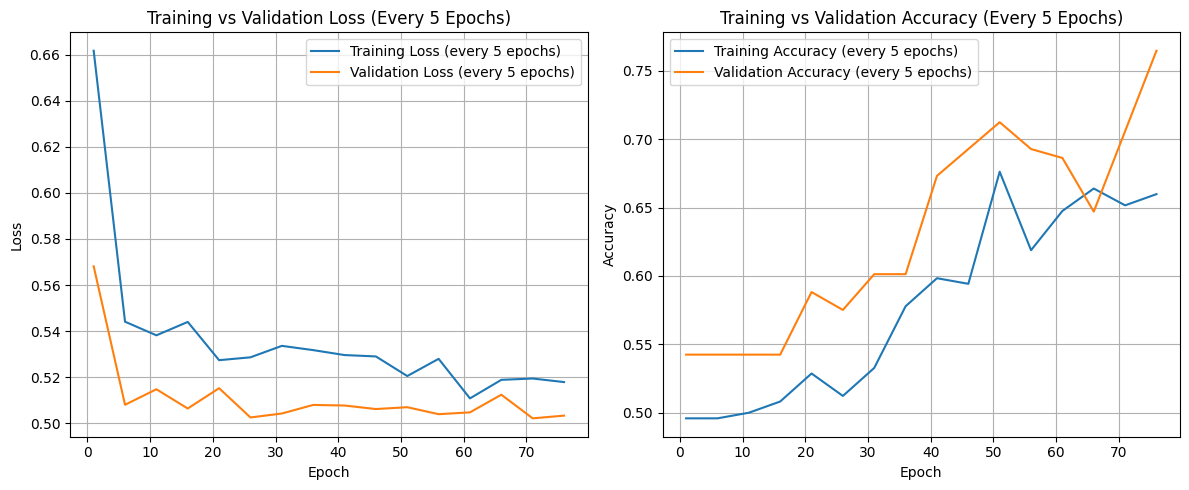

In [14]:
# Plot metrics every 5th epoch
plt.figure(figsize=(12, 5))

# Plot Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1, 5), train_losses[::5], label='Training Loss (every 5 epochs)')
plt.plot(range(1, num_epochs + 1, 5), val_losses[::5], label='Validation Loss (every 5 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Every 5 Epochs)')
plt.legend()
plt.grid(True)

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1, 5), train_accuracies[::5], label='Training Accuracy (every 5 epochs)')
plt.plot(range(1, num_epochs + 1, 5), val_accuracies[::5], label='Validation Accuracy (every 5 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Every 5 Epochs)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Conclusion

After completing the training and validation process:

1. **Analyze Metrics**: Use the plots to identify the best-performing epoch based on validation loss and accuracy.
2. **Load the Best Model**: Use the provided code to load the model checkpoint for the selected epoch.
3. **Next Steps**:
    - Use the loaded model for further testing on unseen data.
    - Deploy the model to perform predictions on new images.

By selecting the best model, you ensure optimal performance on unseen data while avoiding overfitting or underfitting, making the model suitable for practical applications.

In [15]:
best_model = model.load_state_dict(torch.load('model_epoch_80.pth',weights_only=True))